# Reading and Analizing the Dataframe

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [3]:
df = pd.read_csv("data/orders.csv", header=None)
names = {0: "order_id",
1: "activation_time_local",
2: "country_code",
3: "store_address",
4: "final_status",
5: "payment_status",
6: "products",
7: "products_total",
8: "purchase_total_price"}
df = df.rename(columns=names)

In [4]:
def compare_values(row):
    if row["products_total"] < row["purchase_total_price"]:
        return "under-authorized"
    else:
        return "authorized"
df["auth_status"] = df.apply(compare_values, axis=1)

# Question 1 - What percent of orders are under-authorized? 

In [5]:
under_authorized_count = df[df['auth_status'] == 'under-authorized'].shape[0]

# Calculate the total number of orders
total_orders = df.shape[0]

percentage_under_authorized = (under_authorized_count / total_orders) * 100

print(f"The percentage of orders that are under-authorized is: {percentage_under_authorized:.2f}%")

The percentage of orders that are under-authorized is: 57.58%


/var/folders/k4/q8g97p495cx7f63kbs0wzyc00000gn/T/ipykernel_718/2004358798.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Blues', 2)


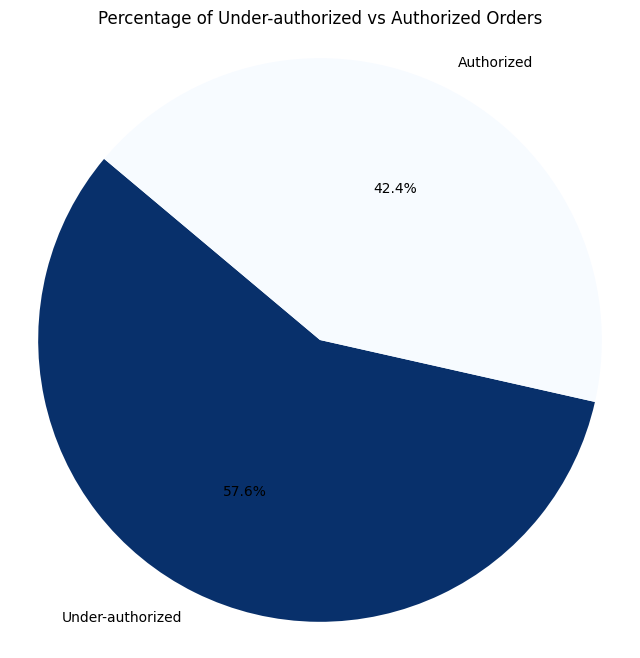

In [77]:
# Count the number of under-authorized orders
under_authorized_count = df[df['auth_status'] == 'under-authorized'].shape[0]

# Count the number of authorized orders
authorized_count = df[df['auth_status'] == 'authorized'].shape[0]

# Calculate the total number of orders
total_orders = df.shape[0]

# Calculate the percentage of under-authorized orders
percentage_under_authorized = (under_authorized_count / total_orders) * 100

# Calculate the percentage of authorized orders
percentage_authorized = (authorized_count / total_orders) * 100

# Define colors for the pie chart slices
colors = cm.get_cmap('Blues', 2)
colors_reversed = list(reversed(colors(range(2))))

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie([under_authorized_count, authorized_count], labels=['Under-authorized', 'Authorized'], autopct='%1.1f%%', startangle=140, colors=colors_reversed)
plt.title('Percentage of Under-authorized vs Authorized Orders')
plt.axis('equal')  

plt.savefig('images/plot1.png')

plt.show()



# Question 2 - What percent of orders would be correctly authorized w/ incremental authorisation

In [7]:
def compare_values_20(row):
    if (row["products_total"]*1.2) < row["purchase_total_price"]:
        return "under-authorized"
    else:
        return "authorized"
df["auth_status_20"] = df.apply(compare_values_20, axis=1)



In [8]:
authorized_20_count = df[df['auth_status_20'] == 'authorized'].shape[0]

# Calculate the total number of orders
total_orders = df.shape[0]

percentage_authorized = (authorized_20_count / total_orders) * 100

print(f"The percentage of orders that are authorized is: {percentage_authorized:.2f}%")

The percentage of orders that are authorized is: 69.03%


/var/folders/k4/q8g97p495cx7f63kbs0wzyc00000gn/T/ipykernel_718/1173921446.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Greens', 2)


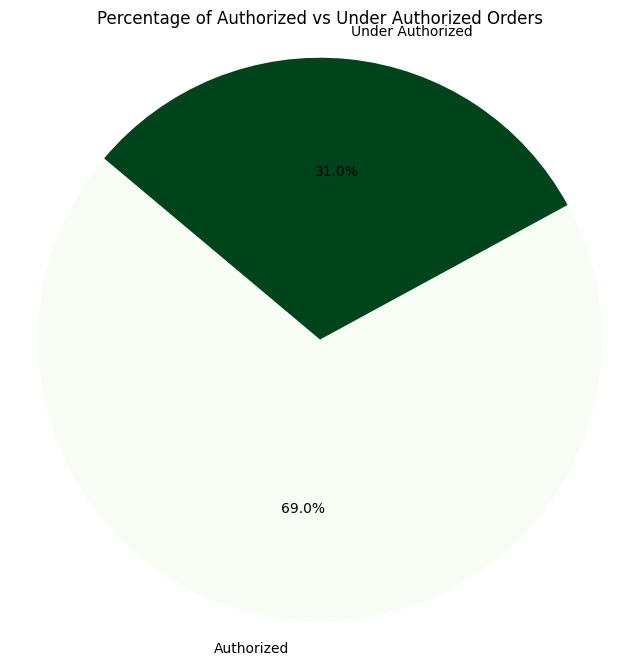

In [78]:
import matplotlib.pyplot as plt

# Assuming df is a DataFrame with a column 'auth_status_20' that indicates whether an order is authorized or not

# Count the number of authorized orders
authorized_20_count = df[df['auth_status_20'] == 'authorized'].shape[0]

# Calculate the total number of orders
total_orders = df.shape[0]

# Calculate the percentage of authorized orders
percentage_authorized = (authorized_20_count / total_orders) * 100

# Define colors for the pie chart slices
colors = cm.get_cmap('Greens', 2)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie([authorized_20_count, total_orders - authorized_20_count], labels=['Authorized', 'Under Authorized'], autopct='%1.1f%%', startangle=140, colors=colors(range(2)))
plt.title('Percentage of Authorized vs Under Authorized Orders')
plt.axis('equal')  

plt.savefig('images/plot2.png')

plt.show()

# Question 3 - Are there differences when split by country? 

In [10]:
#Create a Subset for all under-authorized orders:
df_filtered_under = df[df["auth_status"] == "under-authorized"]
#Group by country code
country_totals = pd.DataFrame(df_filtered_under.groupby('country_code')['products_total'].sum())

We want to see the percentaje of under-authorized orders for each country. To simplify the plot and avoid noise, we will group all countries that represent bellow 2% of under-authorized orders in a group call "Others"

In [11]:
#1. Create a new index (to modify the country_code)
country_totals = country_totals.reset_index(drop=False)
#2. Set the threshold (under 2%)
threshold = (country_totals["products_total"].sum())*0.02

#3. Defing a function to modiffy country code base on threshold
def other_country(row):
    if row['products_total'] < threshold:
        return 'Other'
    else:
        return row['country_code']
    
#4. Apply the function:
country_totals['country_code'] = country_totals.apply(other_country, axis=1)

We plot the results:

/var/folders/k4/q8g97p495cx7f63kbs0wzyc00000gn/T/ipykernel_718/3439782243.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('YlOrBr', len(country_tot))


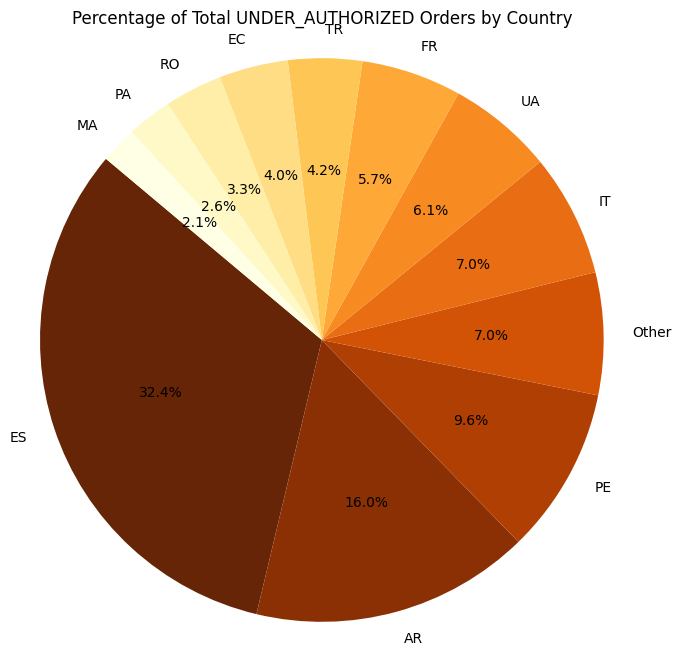

In [79]:
country_tot = country_totals.groupby('country_code')['products_total'].sum()
#sorted
country_tot = country_tot.sort_values(ascending=False)

colors = cm.get_cmap('YlOrBr', len(country_tot))
colors_reversed = list(reversed(colors(range(len(country_tot)))))


plt.figure(figsize=(8, 8))
plt.pie(country_tot, labels=country_tot.index, autopct='%1.1f%%', startangle=140, colors=colors_reversed)
plt.title('Percentage of Total UNDER_AUTHORIZED Orders by Country')
plt.axis('equal')

plt.savefig('images/plot3.png')

plt.show()

# Question 4 - For the remainder of orders that would be outside of incremental auth what  values would be necessary to capture the remaining amount?

In [13]:
df["products_total_20"] = df["products_total"]*1.2

In [14]:
df['price_difference'] = 0  

df.loc[df['purchase_total_price'] > df['products_total_20'], 'price_difference'] = df['purchase_total_price'] - df['products_total_20']

/var/folders/k4/q8g97p495cx7f63kbs0wzyc00000gn/T/ipykernel_718/3816190762.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.192 3.048 7.71  ... 2.298 2.762 3.212]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['purchase_total_price'] > df['products_total_20'], 'price_difference'] = df['purchase_total_price'] - df['products_total_20']


# Question 5 - Which stores are the most problematic in terms of orders and monetary value?  

In [43]:
#Monetary value - analice unpaid orders:

# create a sub-set
df_mv = df[["store_address", "payment_status", "products_total", "purchase_total_price"]]

#function new colum for unpaid amount
def unpaid(row):
    if row['purchase_total_price'] == 0:
        return row['products_total']
    else:
        return row['purchase_total_price']
    
#apply function:
df_mv["unpaid"] = df_mv.apply(unpaid, axis=1)

/var/folders/k4/q8g97p495cx7f63kbs0wzyc00000gn/T/ipykernel_718/2839564973.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mv["unpaid"] = df_mv.apply(unpaid, axis=1)


In [67]:
df_mv = df_mv[df_mv["payment_status"] == "NOT_PAID"]
paiment_status = pd.DataFrame(df_mv.groupby('store_address')['unpaid'].sum())

top10_unpaid = paiment_status.sort_values(by="unpaid", ascending=False).head(10)
unpaid_avg = top10_unpaid["unpaid"].mean()
unpaid_avg

88.29299999999999

# MAKE THE BAR PLOT 

In [ ]:
# Cancelation rate by stores:

In [15]:
# Subset of stores and delibery orders 
df_s1 = df[["store_address","final_status"]]
#Column for how many where Delivered
df_s1["DeliveredStatus"] = df_s1["final_status"].apply(lambda x: 1 if x == "DeliveredStatus" else 0)
#Colum for how many where canceled 
df_s1["CanceledStatus"] = df_s1["final_status"].apply(lambda x: 1 if x == "CanceledStatus" else 0)

/var/folders/k4/q8g97p495cx7f63kbs0wzyc00000gn/T/ipykernel_718/750056383.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s1["DeliveredStatus"] = df_s1["final_status"].apply(lambda x: 1 if x == "DeliveredStatus" else 0)
/var/folders/k4/q8g97p495cx7f63kbs0wzyc00000gn/T/ipykernel_718/750056383.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s1["CanceledStatus"] = df_s1["final_status"].apply(lambda x: 1 if x == "CanceledStatus" else 0)


In [68]:
store_status = pd.DataFrame(df_s1.groupby('store_address')[['DeliveredStatus','CanceledStatus']].sum())
# Sum od orders
store_status["all_orders"] = store_status["CanceledStatus"] + store_status["DeliveredStatus"]
# Percentaje of orders canceled:
store_status["canceled"] = (store_status["CanceledStatus"] / store_status["all_orders"])*100

#drop unnecesary columns:
store_status = store_status.drop(columns=['DeliveredStatus', 'CanceledStatus', "all_orders"])

In [80]:
store_status.sort_values(by="canceled", ascending=False).head(5)

,canceled
store_address,
58383,100.0
67350,100.0
48733,100.0
56000,100.0
69329,100.0


In [81]:
store_status["canceled"].value_counts()

canceled
0.000000      2911
100.000000     382
50.000000      249
33.333333      198
25.000000      165
              ... 
1.666667         1
6.000000         1
4.205607         1
7.960199         1
30.555556        1
Name: count, Length: 301, dtype: int64

# DONT' REALLY SE THE POINT OF WHICH -- ALL?¿

# Question 6 For under-auth orders is there a correlation between the difference in the prices and  the cancellation of the order? In other words: Is an order more likely to be cancelled as the price difference increases?  


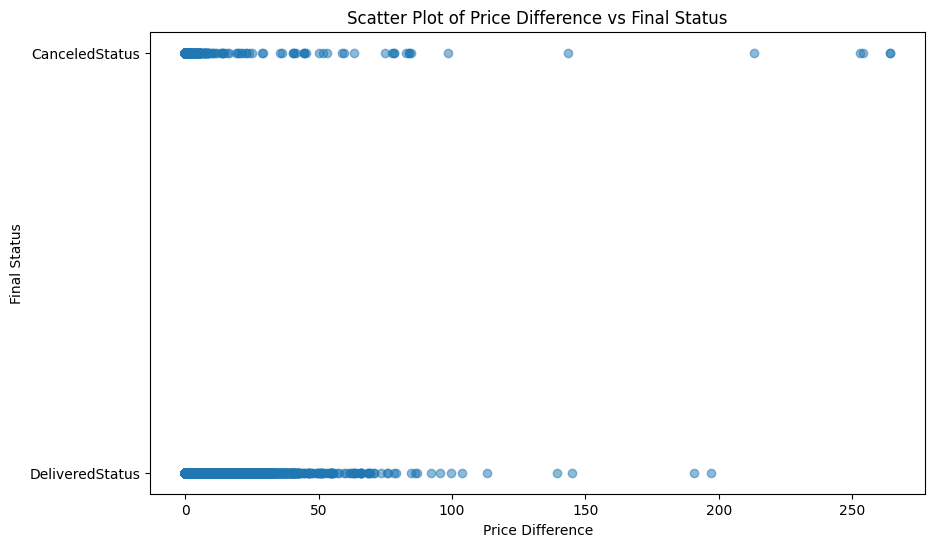

In [14]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the provided data

# Filter out under-authorized orders
under_auth_orders = df[df['auth_status'] == 'under-authorized']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(under_auth_orders['price_difference'], under_auth_orders['final_status'], alpha=0.5)
plt.xlabel('Price Difference')
plt.ylabel('Final Status')
plt.title('Scatter Plot of Price Difference vs Final Status')
plt.show()

In [15]:
import numpy as np

# Assuming df is your DataFrame containing the provided data

# Filter out under-authorized orders
under_auth_orders = df[df['auth_status'] == 'under-authorized']

under_auth_orders['final_status_binary'] = (under_auth_orders['final_status'] == 'CanceledStatus').astype(int)

correlation = np.corrcoef(under_auth_orders['price_difference'], under_auth_orders['final_status_binary'])[0, 1]

print(f"The point-biserial correlation coefficient between price_difference and final_status is: {correlation:.2f}")

The point-biserial correlation coefficient between price_difference and final_status is: 0.12


/var/folders/sz/x51nf6p57096mncqbrxctq940000gn/T/ipykernel_83713/3785033801.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under_auth_orders['final_status_binary'] = (under_auth_orders['final_status'] == 'CanceledStatus').astype(int)
